In [ ]:
# Notes
# Imbalanced dataset, None > Focus Spot > Scratch
# Clear differences between Focus Spot and Scratch
# Scratch has smaller area and larger length, while Focus Spot has the opposite
# Area and length are related to number of clusters

# Imbalanced dataset, might want to use neighbors = 1
# Weights = Distance, closer the better
# Uniform means the top x neighbors would have the same voting power!

#<-------20---------><-------20---------><-------20---------><-------18------->


In [175]:
import joblib
import pickle

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.spatial import ConvexHull
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# 1. Train best classifier (Random Forest)

In [2]:
# Prepare data for modeling
model_df = pd.read_csv('model_dataset/labeled_processed_data.csv')
model_df['class'] = 'none'
model_df.loc[model_df['scratch'] == 1, 'class'] = 'scratch'
model_df.loc[model_df['focus_spot'] == 1, 'class'] = 'focus_spot'
model_df.drop(columns=['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID',
                       'c_id', 'none', 'scratch', 'focus_spot'], inplace=True)
X = model_df.drop(columns='class')
y = model_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.15,
                                                    random_state=11)

# Train model
clf = RandomForestClassifier(n_estimators=700,
                             class_weight='balanced_subsample',
                             min_samples_split=5,
                             min_samples_leaf=1,
                             max_features='auto',
                             max_depth=None,
                             bootstrap=False)
clf.fit(X_train, y_train)

# Save the model to disk
filename = 'gross_failure_classifier.sav'
pickle.dump(clf, open(filename, 'wb'))

# Load the model from disk
loaded_model = joblib.load(filename)

# 2. Create pipeline for prediction

### Import data, clean, and process

In [309]:
# Input raw data
raw_data_path = 'raw_dataset/QAFQN156KOG7.csv'

In [310]:
df = pd.read_csv(raw_data_path)
df.rename(columns={'REAL_WAFER_X': 'X', 'REAL_WAFER_Y': 'Y'}, 
          inplace=True)
df[['X', 'Y']] = df[['X', 'Y']]/1000

### Perform clustering

In [311]:
# Cluster with DBSCAN and HDBSCAN
clusterer = DBSCAN(eps=10, min_samples=4).fit(df[['X', 'Y']])
df['c_id'] = 1 + clusterer.labels_
df_sub = df.copy()
clusterer = hdbscan.HDBSCAN(min_samples=4)
clusterer.fit(df_sub[['X', 'Y']])
df_sub['c_id'] = 1 + clusterer.labels_
df = pd.merge(df, df_sub[['X', 'Y', 'c_id']], 
              on=['X', 'Y'], suffixes=('', '_y'))
df.loc[
    (df['c_id'] == 0) & (df['c_id_y'] != 0), 'c_id'] = df.loc[
    (df['c_id'] == 0) & (df['c_id_y'] != 0),
    'c_id_y'] + df['c_id'].max()
df.drop(columns='c_id_y', inplace=True)

# Any clusters that are less than 4 samples are not considered issues
cluster_size = df['c_id'].value_counts()
df.loc[df['c_id'].map(cluster_size) <= 4, 'c_id'] = 0

### Calculate features

In [312]:
# Initialize functions for calculating features
def PolygonArea(xy):
    """Calculate the area of xy coordinates.
    
    Arg:
        xy (array): 2D array with x coordinates as the first column and 
            y coordinates as the second column
    Return:
        polygon_area (float): Area of the shape createdd by xy coordinates
    """
    x = xy[:, 0]
    y = xy[:, 1]
    x_ = x - x.mean()
    y_ = y - y.mean()
    correction = x_[-1]*y_[0] - y_[-1]*x_[0]
    main_area = np.dot(x_[:-1], y_[1:]) - np.dot(y_[:-1], x_[1:])
    polygon_area = 0.5*np.abs(main_area + correction)
    return polygon_area

def area(cluster_df):
    """Calculate the area of the outer xy coordinates of the cluster.
    
        Arg:
            cluster_df (dataframe): Cluster dataframe containing xy coordinate 
                columns
        Return:
            cluster_area (float): Area of the cluster created by outer xy 
                coordinates
    """
    cluster_xy = cluster_df[['X', 'Y']].values
    if cluster_xy.shape[0] < 3:
        cluster_area = 0
    else:
        if (all(cluster_xy[:, 0] == cluster_xy[1, 0]) 
            | all(cluster_xy[:, 1] == cluster_xy[1, 1])):
            cluster_area = 0
        else:
            hull = ConvexHull(cluster_xy)
            hull_pts = cluster_xy[hull.vertices, :]
            cluster_area = PolygonArea(hull_pts)
    return cluster_area

def cluster_length(cluster_df):
    """Calculate the length of the cluster.
    
    Arg:
        cluster_df (dataframe): Cluster dataframe containing xy coordinate 
            columns
    Return:
        cluster_len (float): Length of the cluster that is determined by 
            the two points furthest away from each other
    """
    cluster_xy = cluster_df[['X', 'Y']].values
    if cluster_xy.shape[0] < 2:
        cluster_len = 0
    else:
        dist_arr = np.sqrt(np.sum(cluster_xy**2,axis=1))
        coordA = cluster_xy[np.argmax(dist_arr), :]
        cdf_moved = cluster_xy[:] - coordA[:]
        dist_arr = np.sqrt(np.sum(cdf_moved**2,axis=1))
        coordB = cluster_xy[np.argmax(dist_arr), :]
        cluster_len = np.linalg.norm(coordA - coordB)
    return cluster_len

In [313]:
num_wafer_pt_df = (df.groupby(
                   ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID'])
                         .size()
                         .reset_index())
num_wafer_pt_df.rename(columns={0: 'NUM_WAFER_PT'}, inplace=True)
cent_wafer_xy_df = (df.groupby(
                    ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID'])
                          .agg({'X': np.mean, 'Y': np.mean})
                          .reset_index())
cent_wafer_xy_df.rename(
    columns={'X': 'WAFER_CENTX', 'Y': 'WAFER_CENTY'}, inplace=True)
num_cluster_df = df.loc[df['c_id'] != 0, :].copy()
num_cluster_df = (num_cluster_df.groupby(
                  ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID'])
                                .agg({'c_id': 'nunique'})
                                .reset_index())
num_cluster_df.rename(
    columns={'c_id': 'NUM_CLUSTER'}, inplace=True)
wafer_feat_df = num_wafer_pt_df.merge(cent_wafer_xy_df)
wafer_feat_df = wafer_feat_df.merge(num_cluster_df, how='left')
wafer_feat_df['NUM_CLUSTER'].fillna(0, inplace=True)
num_cluster_pt_df = (df.groupby(
                     ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID', 'c_id'])
                                 .size()
                                 .reset_index())
num_cluster_pt_df.rename(columns={0: 'NUM_PT'}, inplace=True)
cent_cluster_xy_df = (df.groupby(
                      ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID', 'c_id'])
                                  .agg({'X': np.mean, 'Y': np.mean})
                                  .reset_index())
cent_cluster_xy_df.rename(
    columns={'X': 'CENTX', 'Y': 'CENTY'}, inplace=True)
cent_cluster_xy_df['DIST_FROM_CENTER'] = np.sqrt(
    cent_cluster_xy_df['CENTX']**2 
    + cent_cluster_xy_df['CENTY']**2)
area_cluster_df = (df.groupby(
                   ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID', 'c_id'])
                               .apply(area)
                               .reset_index())
area_cluster_df.rename(columns={0: 'AREA'}, inplace=True)
len_cluster_df = (df.groupby(
                  ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID', 'c_id'])
                              .apply(cluster_length)
                              .reset_index())
len_cluster_df.rename(columns={0: 'LENGTH'}, inplace=True)
cluster_feat_df = num_cluster_pt_df.merge(cent_cluster_xy_df)
cluster_feat_df = cluster_feat_df.merge(cent_cluster_xy_df)
cluster_feat_df = cluster_feat_df.merge(area_cluster_df)
cluster_feat_df = cluster_feat_df.merge(len_cluster_df)
all_feat_df = cluster_feat_df.merge(wafer_feat_df)

not_clustered = all_feat_df[all_feat_df['c_id'] == 0].copy()
all_feat_df = all_feat_df[all_feat_df['c_id'] != 0]

### Predict failure area type of clusters

In [314]:
feat_only_df = all_feat_df.drop(
    columns=['c_id', 'LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID'])
all_feat_df['PRED'] = loaded_model.predict(feat_only_df)
pred_df = pd.concat((not_clustered, all_feat_df))
pred_df.loc[pred_df['PRED'].isna(), 'PRED'] = 'none'

labeled_df = pd.merge(df, 
                      pred_df[['LOT_ID', 'WAFER_ID', 
                               'WAFER_SCRIBE_ID', 'c_id', 'PRED']],
                      on=['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID', 'c_id'],
                      how='left')

In [317]:
# All none predictions have cluster ids set to 0
relabeled_df = labeled_df.copy()
c_id_mapping = (relabeled_df.loc[relabeled_df['PRED'] != 'none', ['c_id', 'PRED']]
     .drop_duplicates()
     .sort_values(by='PRED', ascending=True))
c_id_mapping['c_id_new'] = range(1, c_id_mapping.shape[0] + 1)
relabeled_df = pd.merge(relabeled_df,
                        c_id_mapping[['c_id', 'c_id_new']],
                        on='c_id',
                        how='left').drop(columns='c_id').rename(columns={'c_id_new': 'c_id'})
relabeled_df.loc[relabeled_df['c_id'].isna(), 'c_id'] = 0
relabeled_df['c_id'] = relabeled_df['c_id'].astype(int)

### 3. Present predictions

In [333]:
# Rename data columns
relabeled_df.columns = ['Lot ID', 'Wafer ID', 'Wafer Scribe ID', 'Inspection Date', 'X', 'Y', 'Pred. Type', 'Pred. Cluster ID']

In [334]:
# Summarize predictions
pred_summary = pred_df[pred_df['PRED'] != 'none'].groupby(['PRED']).size().reset_index()
pred_summary.rename(columns={'PRED': 'Pred. Type',
                             0: 'Total'},
                    inplace=True)
pred_summary['Pred. Type'] = pred_summary['Pred. Type'].map(
    {'focus_spot': 'Focus Spot', 'scratch': 'Scratch'})

In [338]:
noneType_df = relabeled_df[relabeled_df['Pred. Type'] == 'none'].copy()
detectedType_df = relabeled_df[relabeled_df['Pred. Type'] != 'none'].copy()

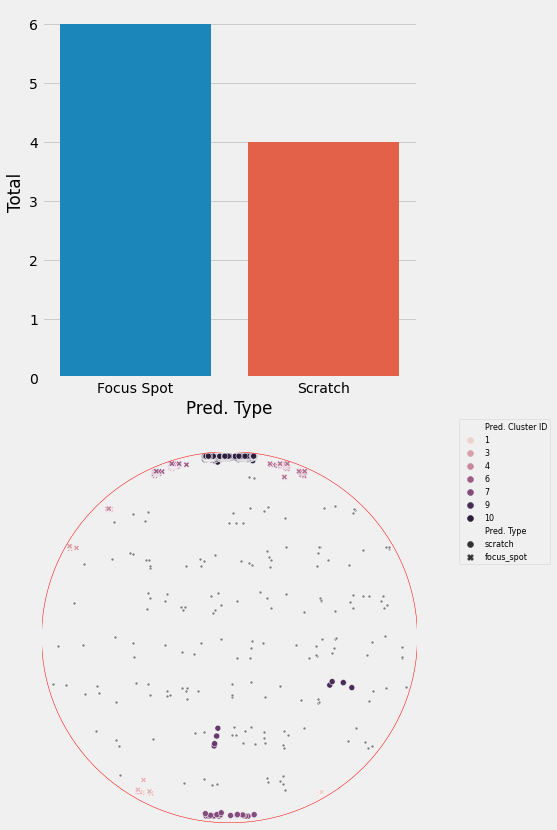

In [347]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2, 1, figsize=(6, 14))
sns.barplot(x='Pred. Type', y='Total', data=pred_summary, ax=ax[0])
if ~noneType_df.empty:
    sns.scatterplot(x='X', y='Y', data=noneType_df,
                    color='grey', ax=ax[1], marker='.')
if ~detectedType_df.empty: 
    sns.scatterplot(x='X', y='Y', data=detectedType_df,
                    hue='Pred. Cluster ID', style='Pred. Type', ax=ax[1])
plt.xlim([-150, 150])
plt.ylim([-150, 150])
plt.axis('off')
circle = plt.Circle((0, 0), 150, color='r', fill=None)
ax[1].add_patch(circle)
plt.legend(bbox_to_anchor=(1.1, 1.1), loc='upper left', ncol=1, prop={'size': 8})
plt.show()